# Setup

In [1]:
counting_method = False
counting_method = True # <--

# Set to True if running on Google Colab
google_colab = False
# google_colab = True # <--

calculate_mode = False
# calculate_mode = True # <--

save_result = False
# save_result = True # <--
    
if calculate_mode == False:
    save_result = False

In [2]:
import os
import sys
import time
import csv
import numpy as np
import pickle
from tqdm import tqdm
import matplotlib.pyplot as plt

if google_colab == True:
    # Make sure to mount drive and that you have access to IDL_group_project. All paths are from the shared folder
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
#This function will return both the path and the file names of all files in a directory
def path_file_list_creator(path, both_path_file = False):
  path_file_list = []
  for myfile in os.listdir(path):
    full_path = os.path.join(path,myfile)
    if both_path_file == True:
      path_file_list.append((full_path, myfile))
    else:
      path_file_list.append(full_path)
  return(path_file_list,len(path_file_list))

#Concate all different classes semantic information together from seperate directories
def concate_directories(paths):
  semantic_bundles_paths_extended = []
  total_files = 0 

  for path in paths:
    class_bundle_paths , num_files = path_file_list_creator(path)
    semantic_bundles_paths_extended.extend(class_bundle_paths)
    total_files += num_files
  print("Total Files grabbed ", total_files)
  return(semantic_bundles_paths_extended)

# Precision-Recall curve

Load visual concepts

In [4]:
if google_colab == True:
  visual_concepts = np.load('/content/drive/MyDrive/IDL_group_project/visual_concepts_positive.npy')
else:
  # visual_concepts = np.load('/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/visual_concepts_positive_car.npy')
  visual_concepts = np.load('/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/visual_concepts_positive.npy')

# final_indicies = [6, 17, 43, 47, 52, 56, 63, 75, 78, 82, 89, 91, 96, 104, 107, 111, 122, 140, 150, 164, 172, 187, 194]
# visual_concepts = visual_concepts[final_indicies]
num_visual_concepts = visual_concepts.shape[0]
print(visual_concepts.shape)

# # Check the norm of the visual concepts
# for visual_concept in visual_concepts:
#   print(np.linalg.norm(visual_concept))

# # Normalize the visual concepts
# for i in range(len(visual_concepts)):
#   visual_concepts[i] = visual_concepts[i]/np.linalg.norm(visual_concepts[i])

(200, 512)


Load feature vectors

In [5]:
from numpy import linalg as LA

if google_colab == True:
    fp_positive_dir = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/fp_positive/'
    fp_negative_dir = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/fp_negative/'
else:
    fp_positive_dir = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/fp_positive/'
    fp_negative_dir = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/fp_negative/'
    # fp_positive_dir = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/fp_positive_car/'
    # fp_negative_dir = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/fp_negative_car/'

In [6]:
# fp_positive_npy_paths = concate_directories(all_classes_fp_positive_dir)
fp_positive_npy_paths = concate_directories([fp_positive_dir])
fp_negative_npy_paths = concate_directories([fp_negative_dir])

x = np.load(fp_positive_npy_paths[0])
y = np.load(fp_negative_npy_paths[0])
print(LA.norm(x - y).item())

# Shuffle the feature vector sets the same way
import random
fp_all_npy_paths = list(zip(fp_positive_npy_paths, fp_negative_npy_paths))
random.shuffle(fp_all_npy_paths)
fp_positive_npy_paths, fp_negative_npy_paths = zip(*fp_all_npy_paths)

print(fp_positive_npy_paths[:3])
print(fp_negative_npy_paths[:3])

# Take a subset to reduce the computation time
dataset_cutoff = len(fp_positive_npy_paths)
fp_positive_npy_paths = fp_positive_npy_paths[:dataset_cutoff]
fp_negative_npy_paths = fp_negative_npy_paths[:dataset_cutoff]
print(len(fp_negative_npy_paths))

Total Files grabbed  3351
Total Files grabbed  3351
35.96550750732422
('/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/fp_positive/01557.npy', '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/fp_positive/01209.npy', '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/fp_positive/01653.npy')
('/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/fp_negative/01557.npy', '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/fp_negative/01209.npy', '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/fp_negative/01653.npy')
3351


Create a set of thresholds

In [7]:
thresholds = np.linspace(0.5, 1.5, 101, endpoint=True)
num_thresholds = len(thresholds)
print(thresholds)

[0.5  0.51 0.52 0.53 0.54 0.55 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63
 0.64 0.65 0.66 0.67 0.68 0.69 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77
 0.78 0.79 0.8  0.81 0.82 0.83 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91
 0.92 0.93 0.94 0.95 0.96 0.97 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05
 1.06 1.07 1.08 1.09 1.1  1.11 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19
 1.2  1.21 1.22 1.23 1.24 1.25 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33
 1.34 1.35 1.36 1.37 1.38 1.39 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47
 1.48 1.49 1.5 ]



Calculate the norm, compare to the thresholds

In [8]:
if counting_method == True:
  feature_vector_cutoff = 50
else:
  feature_vector_cutoff = 200

def check_firing(fp_npy_paths, visual_concepts, thresholds, type):
  num_visual_concepts = visual_concepts.shape[0]
  num_thresholds = len(thresholds)
    
  firing_result_list = []
  firing_result_array = np.zeros(shape=(num_thresholds, num_visual_concepts), dtype=np.int32) # num_T * 200 elements

  if counting_method == True: # Count all the fires
    for i in tqdm(range(len(fp_npy_paths))):
      feature_vectors = np.load(fp_npy_paths[i])
      np.random.shuffle(feature_vectors)
      for feature_vector in feature_vectors[:feature_vector_cutoff]:
        for j in range(num_visual_concepts):
          norm = LA.norm(feature_vector - visual_concepts[j]).item()
          for k in range(num_thresholds):
            if norm < thresholds[k]:
              firing_result_array[k, j] += 1
  else: # Assign 1 for any fire
    for i in tqdm(range(len(fp_npy_paths))):
      feature_vectors = np.load(fp_npy_paths[i])
      np.random.shuffle(feature_vectors)
      for feature_vector in feature_vectors[:feature_vector_cutoff]:
        for j in range(num_visual_concepts):
          if firing_result_array[:, j].any() == 0:
            norm = LA.norm(feature_vector - visual_concepts[j]).item()
            for k in range(num_thresholds):
              if norm < thresholds[k]:
                firing_result_array[k, j] = 1
                
  for i in range(num_thresholds):
    firing_result_dict = {'T': thresholds[i], type: firing_result_array[i]}
    firing_result_list.append(firing_result_dict)
    
  plt.imshow(firing_result_array, interpolation='none')
  plt.xlabel('Visual concept')
  plt.ylabel('T')
  plt.show()
    
  return firing_result_list

if calculate_mode == True:
  print('Positive')
  positive_firing_result_list = check_firing(fp_positive_npy_paths, visual_concepts, thresholds, type='positive')
  print('Negative')
  negative_firing_result_list = check_firing(fp_negative_npy_paths, visual_concepts, thresholds, type='negative')

Save and load the results

In [9]:
if counting_method == True:
    if google_colab == True:
        positive_firing_result_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/positive_counting.pkl'
        negative_firing_result_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/negative_counting.pkl'
    else:
        positive_firing_result_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/positive_counting.pkl'
        negative_firing_result_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/negative_counting.pkl'
else:
    if google_colab == True:
        positive_firing_result_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/positive_binary.pkl'
        negative_firing_result_path = '/content/drive/MyDrive/IDL_group_project/Google_Colab/data/negative_binary.pkl'
    else:
        positive_firing_result_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/positive_binary.pkl'
        negative_firing_result_path = '/home/tunx404/Cloud/Google Drive - CMU - Shared with me/IDL_group_project/Google_Colab/data/negative_binary.pkl'

if save_result == True:
    pkl_file = open(positive_firing_result_path, 'wb')
    pickle.dump(positive_firing_result_list, pkl_file)
    pkl_file.close()

    pkl_file = open(negative_firing_result_path, 'wb')
    pickle.dump(negative_firing_result_list, pkl_file)
    pkl_file.close()

if calculate_mode == False:
    with open(positive_firing_result_path, 'rb') as f:
        positive_firing_result_list = pickle.load(f)
    with open(negative_firing_result_path, 'rb') as f:
        negative_firing_result_list = pickle.load(f)
    dataset_cutoff = len(fp_positive_npy_paths) # If reading saved result, set the dataset_cutoff to the same value when saving

Positive


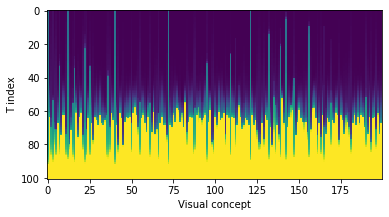

Negative


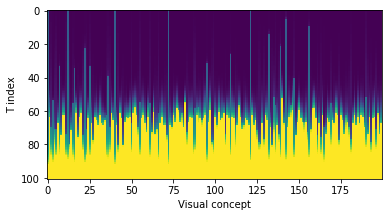

In [10]:
def get_result_array(firing_result_list, type):
    firing_result_array = []
    for firing_result in firing_result_list:
        firing_result_array.append(np.expand_dims(firing_result[type], axis=0))
    firing_result_array = np.concatenate(firing_result_array, axis=0)

    plt.imshow(firing_result_array, interpolation='none')
    plt.xlabel('Visual concept')
    plt.ylabel('T index')
    plt.show()
    
    return firing_result_array
    
print('Positive')
positive_firing_result_array = get_result_array(positive_firing_result_list, 'positive')
print('Negative')
negative_firing_result_array = get_result_array(negative_firing_result_list, 'negative')

In [11]:
# num_visual_concepts_new = num_visual_concepts
# first_fire_index = [i for i in range(num_visual_concepts)]

def find_first_fire_indices(firing_result_array):
    NUM_SELECTED_VISUAL_CONCEPTS = 31
    SELECT_THRESHOLD = 100 if counting_method == True else 0
    num_visual_concepts = firing_result_array.shape[1]
    first_fire_indices = []
    for firing_result in firing_result_array:
        for i in range(num_visual_concepts):
            if i not in first_fire_indices:
                if firing_result[i] > SELECT_THRESHOLD:
                    first_fire_indices.append(i)
                    if len(first_fire_indices) > NUM_SELECTED_VISUAL_CONCEPTS:
                        return first_fire_indices
        if len(first_fire_indices) > NUM_SELECTED_VISUAL_CONCEPTS:
            return first_fire_indices
        
positive_first_fire_indices = find_first_fire_indices(positive_firing_result_array)
positive_first_fire_indices.sort()
        
negative_first_fire_indices = find_first_fire_indices(negative_firing_result_array)
negative_first_fire_indices.sort()

for index in positive_first_fire_indices:
    if index in negative_first_fire_indices:
        positive_first_fire_indices.remove(index)

print(positive_first_fire_indices)
print(negative_first_fire_indices)

# final_indicies = [6, 17, 43, 47, 52, 56, 63, 75, 78, 82, 89, 91, 96, 104, 107, 111, 122, 140, 150, 164, 172, 187, 194]
# positive_first_fire_indices = final_indicies

[2, 4, 7, 12, 15, 21, 23, 27, 36, 40, 45, 55, 66, 71, 83, 88]
[0, 2, 3, 4, 5, 7, 11, 12, 13, 15, 16, 22, 23, 25, 35, 36, 37, 40, 42, 50, 55, 61, 66, 72, 87, 88, 95, 98, 99, 109, 121, 126]


[13, 45, 98, 126, 134, 193]
[11, 42, 45, 99, 126, 127, 134, 163, 165, 193]


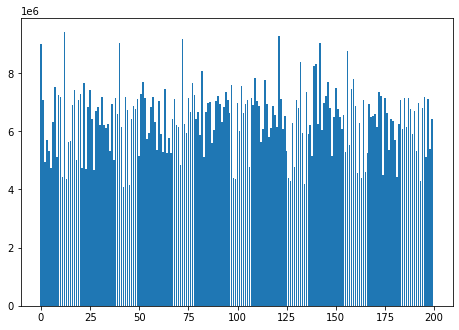

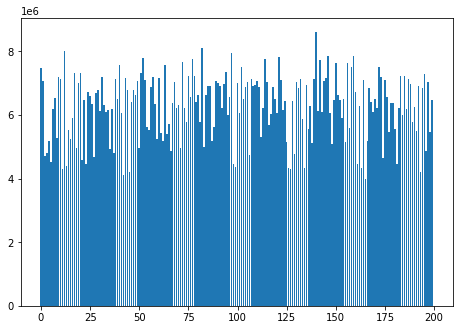

In [12]:
def find_most_fire_indices(firing_result_array):
    NUM_SELECTED_VISUAL_CONCEPTS = 10
    num_visual_concepts = firing_result_array.shape[1]
    count = np.sum(firing_result_array, axis=0)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    indices = [i for i in range(num_visual_concepts)]
    ax.bar(indices, count)
    most_fire_indices = np.argsort(count, axis=0)[:NUM_SELECTED_VISUAL_CONCEPTS]
    return list(most_fire_indices)
    
    # most_fire_indices = []
    # for firing_result in firing_result_array:
    #     for i in range(num_visual_concepts):
    #         if i not in first_fire_indices:
    #             if firing_result[i] > SELECT_THRESHOLD:
    #                 first_fire_indices.append(i)
    #                 if len(first_fire_indices) > NUM_SELECTED_VISUAL_CONCEPTS:
    #                     return first_fire_indices
    #     if len(first_fire_indices) > NUM_SELECTED_VISUAL_CONCEPTS:
    #         return first_fire_indices
        
positive_most_fire_indices = find_most_fire_indices(positive_firing_result_array)
positive_most_fire_indices.sort()
        
negative_most_fire_indices = find_most_fire_indices(negative_firing_result_array)
negative_most_fire_indices.sort()

for index in positive_most_fire_indices:
    if index in negative_most_fire_indices:
        positive_most_fire_indices.remove(index)

print(positive_most_fire_indices)
print(negative_most_fire_indices)

Calculate TP FP FN TN, draw the curves

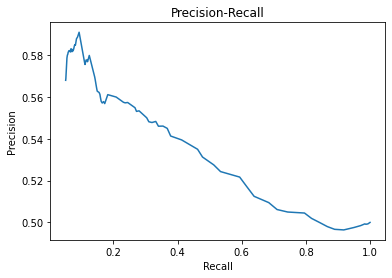

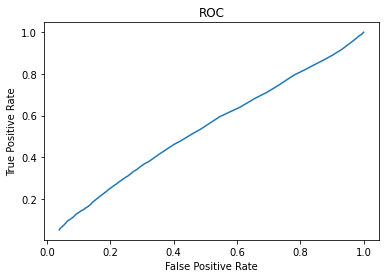

Index 	Threshold 	Precision 	Recall 		TPR 		FPR 		TP 	FP 	FN 	FN
0	0.500000	0.567895	0.051401	0.051401	0.039111	137797	104848	2543003	2575952
1	0.510000	0.568704	0.051974	0.051974	0.039417	139333	105668	2541467	2575132
2	0.520000	0.578517	0.055343	0.055343	0.040320	148363	108091	2532437	2572709
3	0.530000	0.579179	0.055971	0.055971	0.040668	150048	109022	2530752	2571778
4	0.540000	0.579767	0.056561	0.056561	0.040997	151630	109906	2529170	2570894
5	0.550000	0.580092	0.057115	0.057115	0.041344	153114	110834	2527686	2569966
6	0.560000	0.580202	0.057664	0.057664	0.041722	154585	111848	2526215	2568952
7	0.570000	0.580532	0.058299	0.058299	0.042125	156289	112928	2524511	2567872
8	0.580000	0.581188	0.059013	0.059013	0.042525	158201	114002	2522599	2566798
9	0.590000	0.581412	0.059642	0.059642	0.042939	159887	115111	2520913	2565689
10	0.600000	0.581591	0.060276	0.060276	0.043364	161587	116249	2519213	2564551
11	0.610000	0.581781	0.060937	0.060937	0.043805	163360	117433	2517440	2563367
12	0.6200

In [13]:
# num_visual_concepts_new = num_visual_concepts
# positive_most_fire_indices = [i for i in range(num_visual_concepts)]

precisions = []
recalls = []
TPRs = []
FPRs = []
TPs = []
FPs = []
FNs = []
TNs = []

num_visual_concepts_new = len(positive_first_fire_indices)
for i in range(num_thresholds):
  threshold = positive_firing_result_list[i]['T']

  true_positive  = sum(positive_firing_result_list[i]['positive'][positive_first_fire_indices])
  false_positive = sum(negative_firing_result_list[i]['negative'][positive_first_fire_indices])

  if counting_method == True:
    false_negative = dataset_cutoff*feature_vector_cutoff*num_visual_concepts_new - true_positive  # The number of fp+ not firing
    true_negative  = dataset_cutoff*feature_vector_cutoff*num_visual_concepts_new - false_positive # The number of fp- not firing
  else:
    false_negative = num_visual_concepts_new - true_positive
    true_negative  = num_visual_concepts_new - false_positive
    
  precision = 1.0*true_positive/(true_positive + false_positive + 1e-6)
  if true_positive == 0:
    precision = 1
  recall = 1.0*true_positive/(true_positive + false_negative + 1e-6)
  TPR = 1.0*true_positive/(true_positive + false_negative + 1e-6)
  FPR = 1.0*false_positive/(false_positive + true_negative + 1e-6)

  precisions.append(precision)
  recalls.append(recall)
  TPRs.append(TPR)
  FPRs.append(FPR)
  TPs.append(true_positive)
  FPs.append(false_positive)
  FNs.append(false_negative)
  TNs.append(true_negative)

plt.plot(recalls, precisions)
plt.title('Precision-Recall')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

plt.plot(FPRs, TPRs)
plt.title('ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

print('Index \tThreshold \tPrecision \tRecall \t\tTPR \t\tFPR \t\tTP \tFP \tFN \tFN')
for i in range(num_thresholds):
  print(f'{i}\t{thresholds[i]:0.6f}\t{precisions[i]:0.6f}\t{recalls[i]:0.6f}\t{TPRs[i]:0.6f}\t{FPRs[i]:0.6f}\t{TPs[i]:d}\t{FPs[i]:d}\t{FNs[i]:d}\t{TNs[i]:d}')

[Text(0.5, 0, 'Visual concept'), Text(0, 0.5, 'T index')]

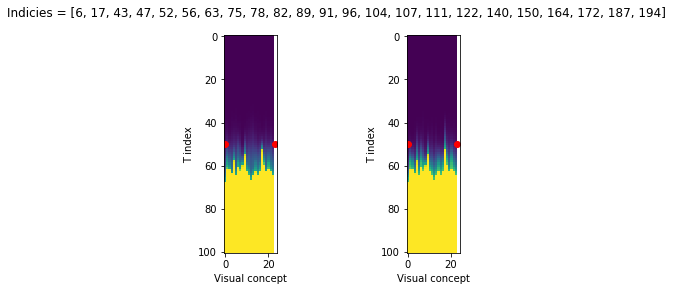

In [14]:
final_indicies = [6, 17, 43, 47, 52, 56, 63, 75, 78, 82, 89, 91, 96, 104, 107, 111, 122, 140, 150, 164, 172, 187, 194]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Indicies = ' + str(final_indicies))
ax1.imshow(positive_firing_result_array[:, final_indicies], interpolation='none')
ax2.imshow(negative_firing_result_array[:, final_indicies], interpolation='none')
ax1.plot(0, 50, len(final_indicies), 50, color='r', marker='o')
ax2.plot(0, 50, len(final_indicies), 50, color='r', marker='o')
ax1.set(xlabel='Visual concept', ylabel='T index')
ax2.set(xlabel='Visual concept', ylabel='T index')